In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(1)


cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
training_parameters = {
    "n_epochs": 100,
    "batch_size": 4,
}
#data_loader = torch.utils.data.DataLoader( '/content/drive/My Drive/LOP_DATASET/train/',batch_size=training_parameters["batch_size"], shuffle=True)

In [ ]:
batch_size = 4
train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
train_dataset = datasets.ImageFolder(root='/content/drive/My Drive/LOP_DATASET/train/', transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
'''#EPOCHS = 2
#BATCH_SIZE = 4
#LEARNING_RATE = 0.003
TRAIN_DATA_PATH = ''''/content/drive/My Drive/LOP_DATASET/train'''
#TEST_DATA_PATH = "./images/test/"
'''TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])


train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)'''
#test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
#test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) '''

'TRANSFORM_IMG = transforms.Compose([\n    transforms.Resize(128),\n    transforms.ToTensor(),\n    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])\n\n\ntrain_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)\ntrain_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)'

In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


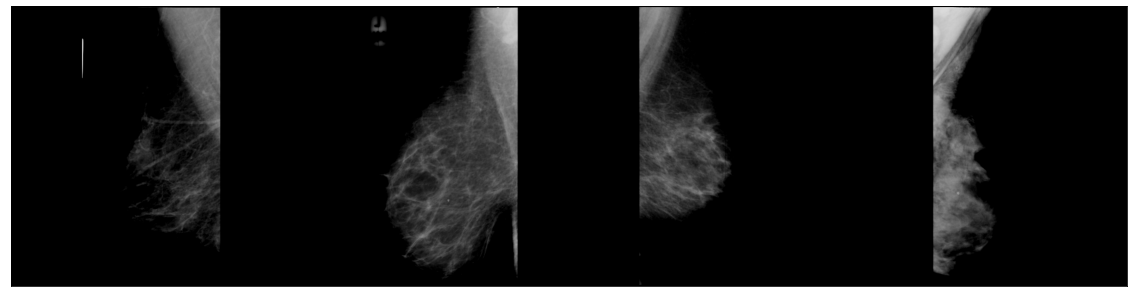

In [ ]:
show_batch(train_loader)


In [ ]:
image_shape = (3, 512, 512)
image_dim = int(np.prod(image_shape))
latent_dim = 100

In [ ]:
n_classes = 2
embedding_dim = 100

In [ ]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim), nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),nn.LeakyReLU(0.2, inplace=True))
           

        self.model =  nn.Sequential(nn.ConvTranspose2d(513, 64*32, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*32, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*32, 64*16, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*16, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*16, 64*8, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)
        #print(latent_output.size(), label_output.size())
        concat = torch.cat((latent_output, label_output), dim=1)
        #concat = torch.cat(512,512)
        image = self.model(concat)
        #print(image.size())
        return image

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(2, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, ke

In [ ]:

a = torch.ones(100)
b = torch.ones(1)
b = b.long()
a = a.to(device)
b = b.to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim), nn.Linear(embedding_dim, 3*512*512))
             
        self.model =  nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(51200, 1),
                      nn.Sigmoid()
                     )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        #print(size(label_output),size(img))
        label_output = label_output.view(-1, 3, 512, 512)
       
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(2, 100)
    (1): Linear(in_features=100, out_features=786432, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)

In [ ]:
a = torch.ones(2,3,512,512)
b = torch.ones(2,1)
b = b.long()
a = a.to(device)
b = b.to(device)

In [ ]:
c = discriminator((a,b))
c.size()

torch.Size([2, 1])

In [ ]:
adversarial_loss = nn.BCELoss()


In [ ]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

In [ ]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [ ]:
!pip install POT

     |████████████████████████████████| 430 kB 12.5 MB/s 


In [ ]:
import math
import os
import timeit
import math

import numpy as np
import ot
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import pdb
from tqdm import tqdm

from scipy.stats import entropy
from numpy.linalg import norm
from scipy import linalg


def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)


def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        # folder dataset
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset


def sampleFake(netG, nz, sampleSize, batchSize, saveFolder):
    print('sampling fake images ...')
    saveFolder = saveFolder + '0/'

    try:
        os.makedirs(saveFolder)
    except OSError:
        pass

    noise = torch.FloatTensor(batchSize, nz, 1, 1).cuda()
    iter = 0
    for i in range(0, 1 + sampleSize // batchSize):
        noise.data.normal_(0, 1)
        fake = netG(noise)
        for j in range(0, len(fake.data)):
            if iter < sampleSize:
                vutils.save_image(fake.data[j].mul(0.5).add(
                    0.5), saveFolder + giveName(iter) + ".png")
            iter += 1
            if iter >= sampleSize:
                break


def sampleTrue(dataset, imageSize, dataroot, sampleSize, batchSize, saveFolder, workers=4):
    print('sampling real images ...')
    saveFolder = saveFolder + '0/'

    dataset = make_dataset(dataset, dataroot, imageSize)
    dataloader = torch.utils.data.DataLoader(
        dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))

    if not os.path.exists(saveFolder):
        try:
            os.makedirs(saveFolder)
        except OSError:
            pass

    iter = 0
    for i, data in enumerate(dataloader, 0):
        img, _ = data
        for j in range(0, len(img)):

            vutils.save_image(img[j].mul(0.5).add(
                0.5), saveFolder + giveName(iter) + ".png")
            iter += 1
            if iter >= sampleSize:
                break
        if iter >= sampleSize:
            break



class ConvNetFeatureSaver(object):
    def __init__(self, model='resnet34', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, save2disk=False):
        dataset = dset.ImageFolder(root=imgFolder, transform=self.trans)
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, num_workers=self.workers)
        print('extracting features...')
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []
        for img, _ in tqdm(dataloader):
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'vgg' or self.model == 'vgg16':
                    fconv = self.vgg.features(input).view(input.size(0), -1)
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        if save2disk:
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_pixl.pth'))
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_conv.pth'))
            torch.save(feature_logit, os.path.join(
                imgFolder, 'feature_logit.pth'))
            torch.save(feature_smax, os.path.join(
                imgFolder, 'feature_smax.pth'))

        return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1)
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1)
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_real = s.tp / (s.tp + s.fn)
    s.acc_fake = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k
    print("Prcision:", s.precision, "Recall:", s.recall, "Accuracy:", s.acc)
    print("\n")
    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())
    print("\nMMD Score:",mmd)
    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))
    print("\nEntropy Score:",scores)
    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem*torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e



eps = 1e-20
def inception_score(X):
    kl = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())
    print("\nInception Score:", score)
    return score

def mode_score(X, Y):
    kl1 = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0)+eps).log()-(Y.mean(0)+eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())
    print("\n Mode Score:", score)
    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
        np.trace(C + C_w - 2 * C_C_w_sqrt)
    print("\nFID:", np.sqrt(score))
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


def compute_score_raw(batchSize, conv_model='resnet34', workers=4):

   # sampleTrue(dataset, imageSize, dataroot, sampleSize, batchSize,
              # saveFolder_r, workers=workers)
   # sampleFake(netG, nz, sampleSize, batchSize, saveFolder_f, )
    saveFolder_f = '/content/drive/My Drive/CGAN/m/';
    saveFolder_r = '/content/drive/My Drive/LOP_DATASET/train/'; 
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,batchSize=batchSize, workers=workers)
    feature_r = convnet_feature_saver.save(saveFolder_r)
    feature_f = convnet_feature_saver.save(saveFolder_f)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(4 * 7 + 3)
    for i in range(0, 4):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_real, tmp.acc_fake, tmp.precision, tmp.recall

    score[28] = inception_score(feature_f[3])
    score[29] = mode_score(feature_r[3], feature_f[3])
    score[30] = fid(feature_r[3], feature_f[3])
    return score

In [ ]:

learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [ ]:
num_epochs = 200
D_loss_plot, G_loss_plot = [], []
outf = '/content/drive/My Drive/CGAN/metrics'
score_tr = np.zeros((num_epochs, 4*7+3))
# compute initial score
#s = compute_score_raw(16,conv_model='inception_v3', workers=int(2))
#score_tr[0] = s
#np.save('%s/score_tr.npy' % (outf), score_tr)

for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
   
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()

      
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
       
        generated_image = generator((noise_vector, labels))
        #print(generated_image), size(labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        #D_fake_loss.backward()
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()


    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_image(generated_image.data[:50], '/content/drive/My Drive/CGAN/m/mimages/sample_%d'%epoch + '.png', nrow=5, normalize=True)
     
    torch.save(generator.state_dict(), '/content/drive/My Drive/CGAN/mweights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), '/content/drive/My Drive/CGAN/mweights/discriminator_epoch_%d.pth' % (epoch))




Epoch: [1/200]: D_loss: 0.339, G_loss: 2.213
extracting features...


100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


extracting features...


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


compute score in space: 0

MMD Score: 0.5616746781718277
Prcision: tensor(0.9965) Recall: tensor(1.) Accuracy: tensor(0.9965)


compute score in space: 1


RuntimeError: ignored

In [ ]:
s = compute_score_raw(16, conv_model='inception_v3', workers=int(2))
score_tr[0] = s



extracting features...


100%|██████████| 18/18 [00:04<00:00,  3.74it/s]


extracting features...


100%|██████████| 11/11 [00:49<00:00,  4.53s/it]


compute score in space: 0

MMD Score: 0.13864479337780386
Prcision: tensor(0.7950) Recall: tensor(0.8982) Accuracy: tensor(0.7935)


compute score in space: 1

MMD Score: 0.4001263746662831
Prcision: tensor(1.) Recall: tensor(1.) Accuracy: tensor(1.)


compute score in space: 2

MMD Score: 0.4003409005899605
Prcision: tensor(0.9930) Recall: tensor(0.9965) Accuracy: tensor(0.9935)


compute score in space: 3

MMD Score: 0.39928727131137115
Prcision: tensor(0.9024) Recall: tensor(0.9088) Accuracy: tensor(0.8826)



Inception Score: tensor(1.4615)

 Mode Score: tensor(1.0591)

FID: tensor(0.1794)


In [ ]:

# save final metric scores of all epoches
np.save('%s/score_tr_ep.npy' % outf, score_tr)
print('##### training completed :) #####')
print('### metric scores output is scored at %s/score_tr_ep.npy ###' % outf)

##### training completed :) #####
### metric scores output is scored at /content/drive/My Drive/CGAN/metrics/score_tr_ep.npy ###


In [ ]:
new_num_arr = np.load('/content/drive/My Drive/CGAN/metrics/score_tr_ep.npy') # load
print(new_num_arr[0])

[1.80077571e+02 1.38644793e-01 7.93478251e-01 8.98245633e-01
 6.22857153e-01 7.95031071e-01 8.98245633e-01 1.01284041e+01
 4.00126375e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 2.04152304e+01 4.00340901e-01
 9.93478239e-01 9.96491253e-01 9.88571405e-01 9.93007004e-01
 9.96491253e-01 1.61052118e-01 3.99287271e-01 8.82608712e-01
 9.08771932e-01 8.39999974e-01 9.02438998e-01 9.08771932e-01
 1.46148288e+00 1.05907416e+00 1.79363281e-01]


In [ ]:
generator.load_state_dict(torch.load('/content/drive/My Drive/CGAN/weights/generator_epoch_174.pth'), strict=False)
generator.eval()

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(2, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, ke

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)


pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])

interpolated = torch.tensor(interpolated)
interpolated = interpolated.to(device)
interpolated = interpolated.type(torch.float32)
output = None
for label in range(2):
    labels = torch.ones(10) * label
    labels = labels.to(device)
    labels = labels.unsqueeze(1).long()
    print(labels.size())
    print("labels:",labels)
    predictions = generator((interpolated, labels))
    predictions = predictions.permute(0,2,3,1)
    pred = predictions.detach().cpu()
    print("pred:"z)
    if output is None:
        output = pred
    else:
        output = np.concatenate((output,pred))

torch.Size([10, 1])
labels: tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
pred: tensor([[[[-0.9973, -0.9963, -0.9961],
          [-0.9998, -0.9997, -0.9999],
          [-0.9999, -0.9998, -0.9997],
          ...,
          [-1.0000, -1.0000, -1.0000],
          [-0.9999, -0.9999, -0.9997],
          [-0.9899, -0.9893, -0.9956]],

         [[-0.9998, -0.9991, -0.9999],
          [-0.9998, -0.9999, -0.9999],
          [-0.9999, -0.9998, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000],
          [-1.0000, -0.9999, -1.0000],
          [-0.9991, -0.9994, -0.9979]],

         [[-0.9999, -0.9999, -0.9996],
          [-1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.9999],
          ...,
          [-1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000],
          [-0.9992, -0.9994, -0.9997]],

         ...,

         [[-0.9996, -0.9981, -0.9995],
          [

In [ ]:
output.shape


(20, 512, 512, 3)

Generated Images are Conditioned on Label: tensor([1], device='cuda:0')


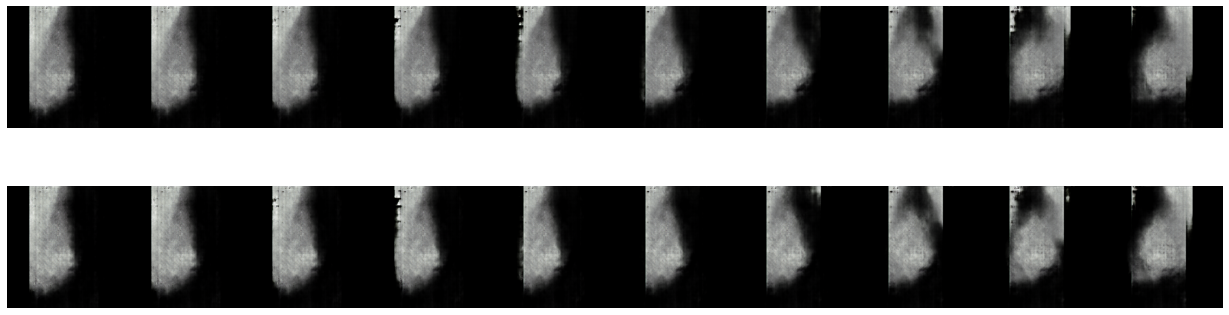

In [ ]:
nrow = 2
ncol = 10
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1,1, 1,1, 1, 1, 1, 1],
     wspace=0.0, hspace=0.0, top=0.2, bottom=0.00, left=0.17, right=0.845) 


print("Generated Images are Conditioned on Label:", labels[1])
k = 0
for i in range(nrow):
    for j in range(ncol):
        pred = (output[k, :, :, :] + 1 ) * 127.5
        pred = np.array(pred)  
        ax= plt.subplot(gs[i,j])
        ax.imshow(pred.astype(np.uint8))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.axis('off')
        k += 1   


#plt.savefig('result_torch.png',  dpi=300)
plt.show()